In [1]:
import torch
from torch.utils.data import Dataset

import torchaudio
import torchaudio.transforms

import sys, os

from pprint import pprint

from tqdm.autonotebook import tqdm

import json

import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import librosa
import librosa.display

import pandas as pd

from pathlib import Path

import gc

MANUAL_SEED = 69

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from datetime import date
from datetime import datetime

import os.path
from os import path

import json

import time

import copy

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE


In [2]:
def make_dir_if_absent(dir_path):
  
  # print("making dir: ", dir_path)
  
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    

In [3]:
def dataset_pca(dataset):
  inputs = []
  outputs = []

  dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=16, num_workers=16, 
  )

  iterator_list = list(iter(dataloader))
  ### len(iterator_list) --> 23
  
  # for batch_input, batch_output in tqdm(iter(dataloader), colour="#FF00FF"):
  for batch_input, batch_output in tqdm(iterator_list, colour="#ff8c00"):
    inputs.append(batch_input) 
    outputs.append(batch_output)

  inputs = torch.cat(tuple(inputs), dim=0).squeeze(1).numpy()
  outputs = torch.cat(tuple(outputs), dim=0).numpy()

  pca = PCA(n_components=2)

  inputs_pca = pca.fit_transform(inputs)

  dataset_pca_tuples = (
    zip(
      inputs_pca[:, 0], inputs_pca[:, 1], outputs, np.argmax(a=outputs, axis=1)
    )
  )

  return pd.DataFrame(
    dataset_pca_tuples, 
    columns = [
      "dataset_pca_1", "dataset_pca_2", "label_one_hot", "label_scalar"
    ]
  )




In [4]:
class FMADataset(Dataset):

  def __init__(
    self, path, normalize_audio, audio_num_frames, mean, std
  ):
    self.path = path
    self.normalize_audio = normalize_audio
    self.audio_num_frames = audio_num_frames
    self.mean = mean
    self.std = std
    
    self.data = self._load_audio_list()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    
    try: 
      
      waveform, _ = torchaudio.load(
        filepath=self.data[idx], 
        normalize=self.normalize_audio,
        num_frames=self.audio_num_frames
      )
      
      if waveform.shape[1] < self.audio_num_frames:
        waveform = self._apply_padding(waveform)
      
      label = self.data[idx].split("/")[-2]
      label_one_hot = self._label_from_str_to_one_hot(label)

      waveform_normalized = (waveform - self.mean) / self.std
      
      return waveform_normalized, label_one_hot
      # return waveform, label_one_hot
    
    except Exception as e:
      print(f"Got the following exception for the file {self.data[idx]}")
      print("\n\n")
      print(e)
      
  def _apply_padding(self, to_pad):
    padding_size = self.audio_num_frames - to_pad.shape[1]
    
    return torch.nn.functional.pad(
      to_pad, (0, padding_size)
    )
  
  def _label_from_str_to_one_hot(self, label_str: str): 
  
    if label_str == "Pop":
      return torch.tensor([1, 0, 0, 0, 0, 0]).float()
    
    if label_str == "Hip-Hop":
      return torch.tensor([0, 1, 0, 0, 0, 0]).float()
    
    if label_str == "Electronic":
      return torch.tensor([0, 0, 1, 0, 0, 0]).float()
    
    if label_str == "Rock":
      return torch.tensor([0, 0, 0, 1, 0, 0]).float()

    if label_str == "Folk":
      return torch.tensor([0, 0, 0, 0, 1, 0]).float()

    if label_str == "Jazz":
      return torch.tensor([0, 0, 0, 0, 0, 1]).float()
    
  
  def _load_audio_list(self):
    
    audio_path_list = []
    
    for path, subdirs, files in tqdm(os.walk(self.path), colour="magenta"):
      for name in files:
          
        file_audio_path = os.path.join(path, name)
        
        audio_path_list.append(file_audio_path)
        
    return audio_path_list
        
        

In [5]:
DATASET_SIZE = "extra_small"
DATASET_FOLDER = "../data/audio"

DATASET_NUM_SAMPLES_PER_SECOND = 8000
DATASET_NUM_CHANNELS = 1

DATASET_NAME = f"fma_{DATASET_SIZE}_organized_by_label_resampled_{DATASET_NUM_SAMPLES_PER_SECOND}_rechanneled_{DATASET_NUM_CHANNELS}"

dataset_path = f"{DATASET_FOLDER}/{DATASET_NAME}"

TRAINING_LOGS_FOLDER = "./logs"

NORMALIZE_AUDIO = True
AUDIO_NUM_FRAMES = 238000

In [6]:
summary_statistics_json = open(
  f"{dataset_path}_summary_statistics/{DATASET_NAME}_summary_statistics.json"
)

summary_statistics_dict = json.load(summary_statistics_json)

In [7]:
summary_statistics_dict

{'dataset_name': 'fma_extra_small_organized_by_label_resampled_8000_rechanneled_1',
 'mean': -0.0001256564719369635,
 'std': 0.252307653427124}

In [8]:
fma_dataset = FMADataset(
  path=dataset_path, 
  normalize_audio=NORMALIZE_AUDIO, 
  audio_num_frames=AUDIO_NUM_FRAMES,
  mean = summary_statistics_dict["mean"], 
  std = summary_statistics_dict["std"]
)

0it [00:00, ?it/s]

In [9]:
dataset_pca_df = dataset_pca(fma_dataset)

  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
scaler = MinMaxScaler()

dataset_pca_df[
  ["dataset_pca_1_min_max_scaled","dataset_pca_2_min_max_scaled"]
] = pd.DataFrame(
  scaler.fit_transform(
    dataset_pca_df[
      ["dataset_pca_1","dataset_pca_2"]
    ].values
  ), 
  columns=["dataset_pca_1_min_max_scaled","dataset_pca_2_min_max_scaled"], 
  index=dataset_pca_df.index
)

In [11]:
make_dir_if_absent(dir_path=f"{dataset_path}_pca")

dataset_pca_df.to_json(
  f"{dataset_path}_pca/{DATASET_NAME}_pca.json"
)

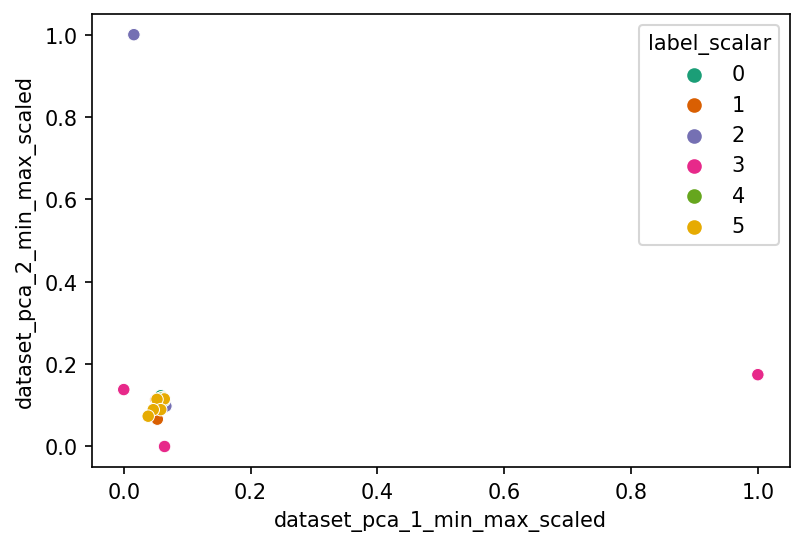

In [12]:
sc = sns.scatterplot(
  data=dataset_pca_df,
  x="dataset_pca_1_min_max_scaled",
  y="dataset_pca_2_min_max_scaled",
  hue="label_scalar",
  palette="Dark2"
)


In [15]:
def dataset_TSNE(dataset):
  inputs = []
  outputs = []

  dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=16, num_workers=16, 
  )

  iterator_list = list(iter(dataloader))
  ### len(iterator_list) --> 23
  
  # for batch_input, batch_output in tqdm(iter(dataloader), colour="#FF00FF"):
  for batch_input, batch_output in tqdm(iterator_list, colour="#ff8c00"):
    inputs.append(batch_input) 
    outputs.append(batch_output)

  inputs = torch.cat(tuple(inputs), dim=0).squeeze(1).numpy()
  outputs = torch.cat(tuple(outputs), dim=0).numpy()

  tsne = TSNE(
    n_components=2,
    perplexity=30 if inputs.shape[0] > 30 else inputs.shape[0] - 1
  )

  inputs_tsne = tsne.fit_transform(inputs)

  dataset_tsne_tuples = (
    zip(
      inputs_tsne[:, 0], inputs_tsne[:, 1], outputs, np.argmax(a=outputs, axis=1)
    )
  )

  return pd.DataFrame(
    dataset_tsne_tuples, 
    columns = [
      "dataset_tsne_1", "dataset_tsne_2", "label_one_hot", "label_scalar"
    ]
  )

In [16]:
dataset_tsne_df = dataset_TSNE(fma_dataset)

  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
dataset_tsne_df[
  ["dataset_tsne_1_min_max_scaled","dataset_tsne_2_min_max_scaled"]
] = pd.DataFrame(
  scaler.fit_transform(
    dataset_tsne_df[
      ["dataset_tsne_1","dataset_tsne_2"]
    ].values
  ), 
  columns=["dataset_tsne_1_min_max_scaled","dataset_tsne_2_min_max_scaled"], 
  index=dataset_tsne_df.index
)

In [18]:
make_dir_if_absent(dir_path=f"{dataset_path}_tsne")

dataset_tsne_df.to_json(
  f"{dataset_path}_tsne/{DATASET_NAME}_tsne.json"
)

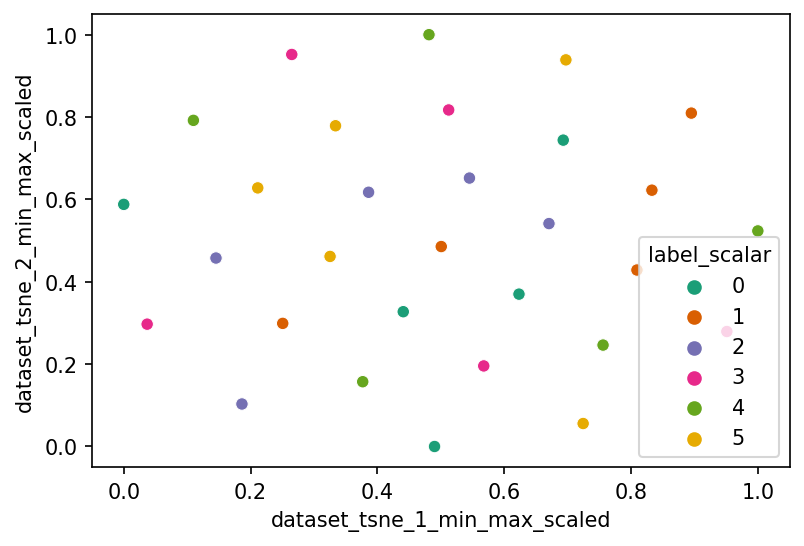

In [19]:
sc = sns.scatterplot(
  data=dataset_tsne_df,
  x="dataset_tsne_1_min_max_scaled",
  y="dataset_tsne_2_min_max_scaled",
  hue="label_scalar",
  palette="Dark2"
)
